In [2]:
%load_ext autoreload
%autoreload 2


# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import xgboost as xgb


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


# Reproduce processing pipeline 

In [5]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .drop_features(["action", "trial", "trial_count", "num_avoids", "max_trial"])
                      .strategy_and_split_by_mouse(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)
processor_pipe.processed_data


,mouse_id,event,sensor,sex,day,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,ratio_avoid
0,0,avoid,D1,F,1,3.127942,-1.445911,183.380890,307.363281,-123.982407,0.178571
1,0,avoid,DA,F,1,2.314936,-3.262590,-107.717682,132.883179,-240.600861,0.178571
2,0,avoid,D1,F,1,2.974904,-1.432352,399.498169,459.798584,-60.300407,0.178571
3,0,avoid,D1,F,1,0.731579,-2.503899,-358.554230,24.004738,-382.558990,0.178571
4,0,avoid,D1,F,1,1.076792,-2.716747,-424.765411,24.113791,-448.879211,0.178571
...,...,...,...,...,...,...,...,...,...,...,...
12416,13,cue,DA,M,7,2.598939,-2.246814,49.042274,189.407471,-140.365204,1.000000
12417,13,escape,D2,M,7,3.042648,-1.698893,159.018143,244.892090,-85.873940,1.000000
12418,13,escape,DA,M,7,3.537512,-2.393753,-82.977081,174.050079,-257.027161,1.000000
12419,13,shock,D2,M,7,3.150901,-1.644451,145.029205,236.765778,-91.736565,1.000000


# Train Regressor using opimtized parameteres

In [6]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evalulate on dev set

In [7]:


mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}")
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 1.6536972466558783e-05
 MSE for optimzied model on development test is 0.08936981644220511
 MSE for optimzied model on test is 0.022681595563793785


# Predict on test set

In [8]:
predicted_performance = model.predict(processor_pipe.X_test)

# Plotting test set vs inference 


In [9]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols + cat_cols
def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
                .assign(male = lambda df_: df_.sex_M.astype(bool))
                .drop(columns=['sex_M', 'sex_F'])
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,mouse_id,day,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,event_avoid,event_cue,event_escape,event_shock,sensor_D1,sensor_D2,sensor_DA,inference_cat,ratio_avoid,male
0,-0.249856,-1.416555,-0.695553,0.523437,-0.173122,-0.626593,0.319242,1.0,0.0,0.0,0.0,1.0,0.0,0.0,predicted_values,0.142282,True
1,-0.249856,-1.416555,1.579697,0.395103,-0.471041,-0.638406,-0.163517,1.0,0.0,0.0,0.0,0.0,0.0,1.0,predicted_values,0.143580,True
2,-0.249856,-1.416555,-0.275176,-0.266413,-1.237924,-1.166851,-0.924201,0.0,1.0,0.0,0.0,1.0,0.0,0.0,predicted_values,0.142928,True
3,-0.249856,-1.416555,2.912181,0.089504,0.064025,0.220974,-0.107655,0.0,1.0,0.0,0.0,0.0,0.0,1.0,predicted_values,0.143143,True
4,-0.249856,-1.416555,0.478908,1.054361,0.778187,0.196755,1.100447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,predicted_values,0.142872,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,1.587260,1.521512,-1.174288,0.112548,-0.242651,-1.082070,0.644718,0.0,0.0,1.0,0.0,0.0,1.0,0.0,true_values,0.928571,False
5222,1.587260,1.521512,0.103718,-0.143197,0.007067,0.237800,-0.218420,0.0,0.0,1.0,0.0,0.0,0.0,1.0,true_values,0.928571,False
5223,1.587260,1.521512,-1.348900,0.183924,-0.525469,-1.082329,0.175827,0.0,0.0,0.0,1.0,0.0,1.0,0.0,true_values,0.928571,False
5224,1.587260,1.521512,-1.292167,0.186598,-0.245389,-1.072643,0.631053,0.0,0.0,0.0,1.0,0.0,1.0,0.0,true_values,0.928571,False


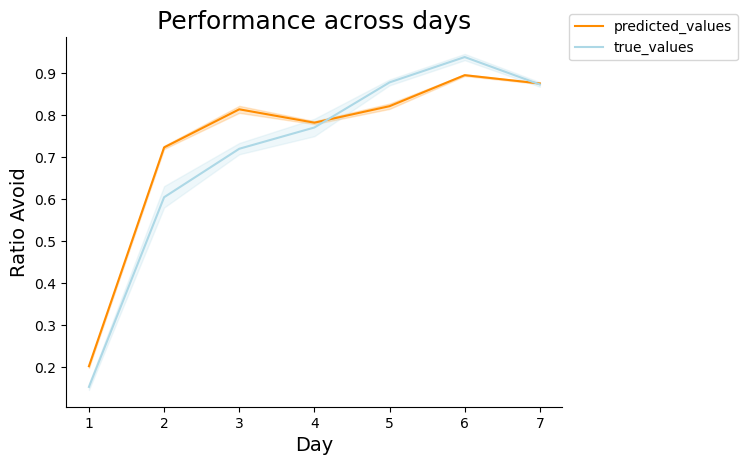

In [10]:
fig, ax = plt.subplots()
sns.lineplot(data=testing_df, x='day', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.0))
plt.xticks(testing_df.day.unique(), np.arange(1,8,1))



ax.set_xlabel('Day', fontsize=14)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Performance across days', fontsize = 18)
sns.despine()

---
# Feature Importance




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

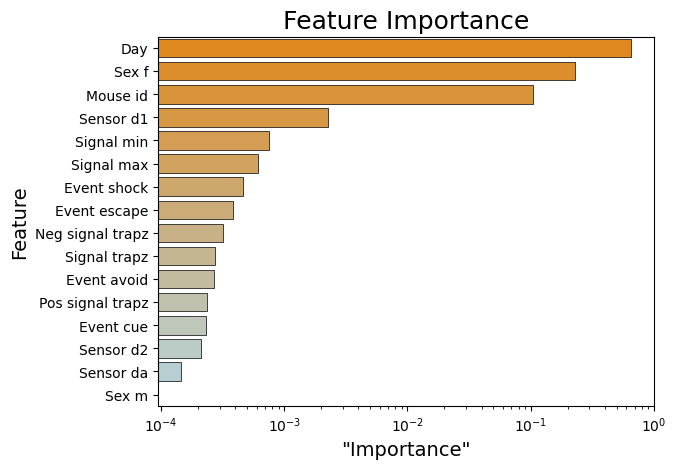

In [12]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(processor_pipe)
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots()
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

In [26]:
testing_df

,mouse_id,day,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_D1,sensor_D2,sensor_DA,inference_cat,ratio_avoid,male
0,-0.249856,-1.416555,-0.695553,0.523437,-0.173122,-0.626593,0.319242,1.0,0.0,0.0,predicted_values,0.143353,True
1,-0.249856,-1.416555,1.579697,0.395103,-0.471041,-0.638406,-0.163517,0.0,0.0,1.0,predicted_values,0.143208,True
2,-0.249856,-1.416555,-0.275176,-0.266413,-1.237924,-1.166851,-0.924201,1.0,0.0,0.0,predicted_values,0.142854,True
3,-0.249856,-1.416555,2.912181,0.089504,0.064025,0.220974,-0.107655,0.0,0.0,1.0,predicted_values,0.143293,True
4,-0.249856,-1.416555,0.478908,1.054361,0.778187,0.196755,1.100447,1.0,0.0,0.0,predicted_values,0.143108,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,1.587260,1.521512,-1.174288,0.112548,-0.242651,-1.082070,0.644718,0.0,1.0,0.0,true_values,0.928571,False
5222,1.587260,1.521512,0.103718,-0.143197,0.007067,0.237800,-0.218420,0.0,0.0,1.0,true_values,0.928571,False
5223,1.587260,1.521512,-1.348900,0.183924,-0.525469,-1.082329,0.175827,0.0,1.0,0.0,true_values,0.928571,False
5224,1.587260,1.521512,-1.292167,0.186598,-0.245389,-1.072643,0.631053,0.0,1.0,0.0,true_values,0.928571,False


## SHAP from feature space

In [13]:
shap_values = shap.TreeExplainer(model).shap_values(processor_pipe.X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(processor_pipe.X_test)

[16:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [15]:
x_train_df = pd.DataFrame(processor_pipe.X_train, columns=cols)

explainer = shap.TreeExplainer(model,x_train_df)
explanation = explainer(x_train_df)

[16:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 7838/7922 [00:43<00:00]        

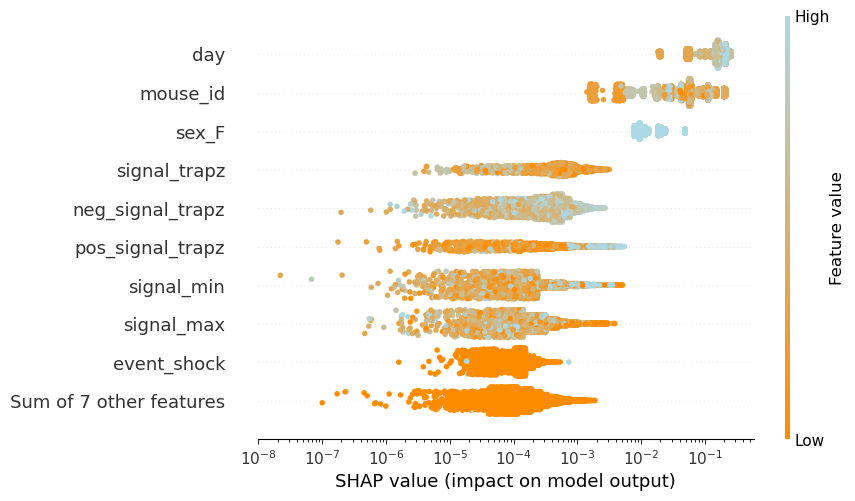

In [19]:
shap.plots.beeswarm(explanation, color=color_map, show=False)
plt.xscale("log")

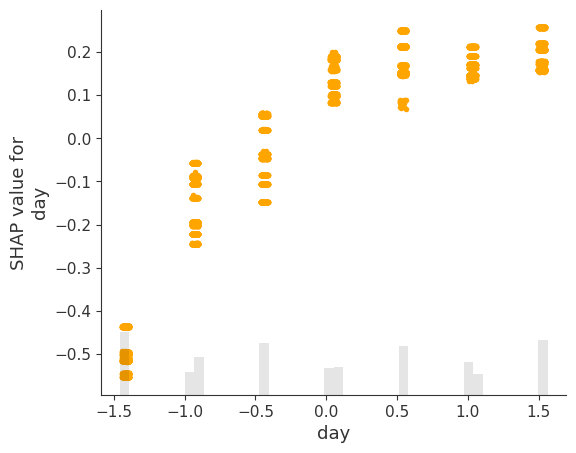

In [17]:

shap.plots.scatter(explanation[:,'day'], show=False, color='orange')



## Dimentional Reduction of SHAP

[16:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 7844/7922 [00:43<00:00]        

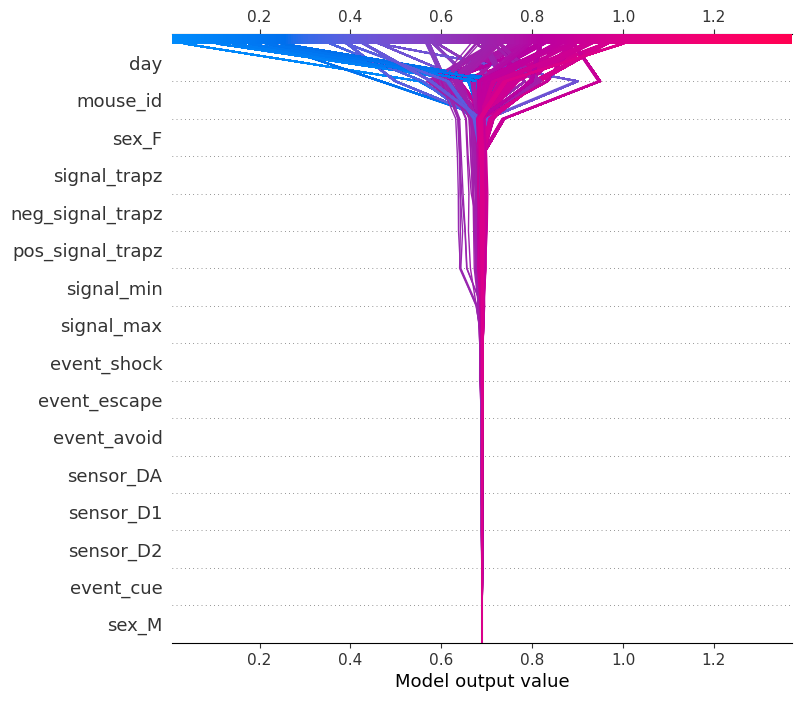

In [18]:
short_explainer = shap.TreeExplainer(model, x_train_df)
short_shap = short_explainer.shap_values(x_train_df)
shap.decision_plot(short_explainer.expected_value, short_shap, features = cols, ignore_warnings= True)

In [ ]:
embeddings = PCA(n_components=2).fit_transform(shap_values.values)
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=len(cols), random_state=42).fit_predict(embeddings)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


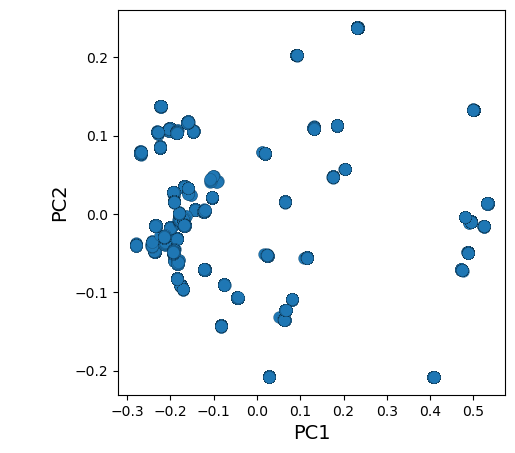

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))


qualitative_colors = sns.color_palette("Set2", len(cols))
sns.scatterplot(x=embeddings[:,0],
                y=embeddings[:,1],
                s=75,
                legend='full',
                edgecolor='black',
                linewidth=0.1,
                ax=ax)

ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)


h,l = ax.get_legend_handles_labels()
ax.legend(h, cols, bbox_to_anchor=(-.25, 1), loc='upper right', borderaxespad=0, frameon=False)



## SHAP from feature space